# **Analysis of Generative Advarsarial Networks**
[Click here for the original paper by Ian Goodfellow](https://https://arxiv.org/pdf/1406.2661.pdf)


Generative Adversarial Networks are a set of models that basically learn to create synthetic data that is similar to input data it's given. In more formal terms, a GAN is a generative model that learns the probability distribution (or data distribution) of the training examples it is given. From this distribution, we can then create sample outputs.

---
**Wine Sellers and fake supplier analogy:**
![alt text](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1524648806/gan_network_eg_jcgooq.jpg)

There are two major components within GANs: the generator and the discriminator. The shop owner in the example is known as a discriminator network and is usually a convolutional neural network (since GANs are mainly used for image tasks) which assigns a probability that the image is real.



The forger is known as the generative network, and is also typically a convolutional neural network (with deconvolution layers). This network takes some noise vector and outputs an image. When training the generative network, it learns which areas of the image to improve/change so that the discriminator would have a harder time differentiating its generated images from the real ones.

The generative network keeps producing images that are closer in appearance to the real images while the discriminative network is trying to determine the differences between real and fake images. The ultimate goal is to have a generative network that can produce images which are indistinguishable from the real ones.

Mathematically, we think about a dataset of examples 
x
1
,
…
,
x
n
 as samples from a true data distribution 
p
(
x
)
. In the example image below, the blue region shows the part of the image space that, with a high probability (over some threshold) contains real images, and black dots indicate our data points (each is one image in our dataset). Now, our model also describes a distribution 
^p
θ
(
x
)
 (green) that is defined implicitly by taking points from a unit Gaussian distribution (red) and mapping them through a (deterministic) neural network — our generative model (yellow). Our network is a function with parameters 
θ
, and tweaking these parameters will tweak the generated distribution of images. Our goal then is to find parameters 
θ
 that produce a distribution that closely matches the true data distribution . Therefore, you can imagine the green distribution starting out random and then the training process iteratively changing the parameters 
θ
 to stretch and squeeze it to better match the blue distribution.
 
 ![alt text](https://blog.openai.com/content/images/2017/02/gen_models_diag_2.svg)


![alt text](https://github.com/adeshpande3/Generative-Adversarial-Networks/raw/384e9f9f7261c9b347979e6d1667986ac320db1e/Images/GAN1.png)
  The above figure clearly illustrates exact working of a typical GAN model.
  
  In this notebook, I am going to follow a simple tutorial to build a GAN model to generate digits based on training from MNIST dataset. Ideally, it should be able to fool the best discriminators( including humans)
  
Here’s what we’re going to need:

Real MNIST training images
A generator network that takes in a random noise vector and produces a synthetic image
A discriminator network (a CNN) that learns to distinguish between real and synthetic images. You can think of it as just a binary classifier (1 for real image, 0 for fake)
An optimization procedure that jointly updates both networks through SGD. This is the tricky part as we need to train the generator network to fool the discriminator network, which means that we have unique gradient flows and labels.
Tensorflow - Our choice of Deep Learning framework

In [0]:
#Lets get started by loading our basic dependencies
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Let's import MNIST dataset into our main memory

We have imported Numpy to help with some matrices, the random library for generating numbers, and Matplotlib for visualizing our image data.

In [2]:

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
x_train = mnist.train.images[:55000,:]
x_train.shape

(55000, 784)

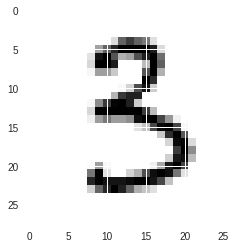

In [6]:
#Let's have a look at a random image
RandomNum = random.randint(0,55000)
image = x_train[RandomNum].reshape([28,28])
plt.imshow(image, cmap=plt.get_cmap('gray_r'))
plt.show()

# Discriminator Network
It would be a convolutional neural network with input size 28x28x1.
The output will be a single scalar number activation that describes whether or not the input image is real or not.

In [0]:
def conv2d(x, W):
  return tf.nn.conv2d(input=x, filter=W, strides=[1, 1, 1, 1], padding='SAME')

def avg_pool_2x2(x):
  return tf.nn.avg_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

To make this discriminator network, we will initialize our weight matrix(filter of size 5x5) with random weights. Output will have a depth of 8.
As with any convolutional neural network, this module is repeated, and then followed by a series of fully connected layers. At the end of the network, we do a final matrix multiply and return the activation value. For those of you comfortable with CNNs, this is just a simple binary classifier. Nothing fancy.

This architecture for this network is based on Tensorflow's sample CNN classifier model that they have explained in detail here: https://www.tensorflow.org/tutorials/mnist/pros/

In [0]:
def discriminator(x_image, reuse=False):
    with tf.variable_scope('discriminator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        #First Conv and Pool Layers
        W_conv1 = tf.get_variable('d_wconv1', [5, 5, 1, 8], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv1 = tf.get_variable('d_bconv1', [8], initializer=tf.constant_initializer(0))
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
        h_pool1 = avg_pool_2x2(h_conv1)

        #Second Conv and Pool Layers
        W_conv2 = tf.get_variable('d_wconv2', [5, 5, 8, 16], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv2 = tf.get_variable('d_bconv2', [16], initializer=tf.constant_initializer(0))
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        h_pool2 = avg_pool_2x2(h_conv2)

        #First Fully Connected Layer
        W_fc1 = tf.get_variable('d_wfc1', [7 * 7 * 16, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc1 = tf.get_variable('d_bfc1', [32], initializer=tf.constant_initializer(0))
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*16])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

        #Second Fully Connected Layer
        W_fc2 = tf.get_variable('d_wfc2', [32, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc2 = tf.get_variable('d_bfc2', [1], initializer=tf.constant_initializer(0))

        #Final Layer
        y_conv=(tf.matmul(h_fc1, W_fc2) + b_fc2)
    return y_conv

# Generator Network
Now that we have our discriminator defined, let’s take a look at the generator module. For this, we’ll be basing our model off the generator introduced in the DCGAN paper (link: https://arxiv.org/pdf/1511.06434v2.pdf). You can think of the generator as being a kind of reverse ConvNet. With CNNs, the goal is to transform a 2 or 3 dimensional matrix of pixel values into a single probability. A generator, however, seeks to take a d-dimensional noise vector and upsample it to become a 28 x 28 image. This upsampling is done through a convolutional transpose (or deconvolution) layer. ReLUs and Batch Norm are then used to stabilize the outputs of each layer.

The structure of the generator is very similar to that of the discriminator, except we're calling the convolution transpose method, instead of the conv2d one.

The conv transpose + relu + batch norm pipeline is repeated 4 times so that the output volume grows larger and larger until a 28 x 28 x 1 image is formed.

In [0]:

def generator(z, batch_size, z_dim, reuse=False):
    with tf.variable_scope('generator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        g_dim = 64 #Number of filters of first layer of generator 
        c_dim = 1 #Color dimension of output (MNIST is grayscale, so c_dim = 1 for us)
        s = 28 #Output size of the image
        s2, s4, s8, s16 = int(s/2), int(s/4), int(s/8), int(s/16) #We want to slowly upscale the image, so these values will help
                                                                  #make that change gradual.

        h0 = tf.reshape(z, [batch_size, s16+1, s16+1, 25])
        h0 = tf.nn.relu(h0)
        #Dimensions of h0 = batch_size x 2 x 2 x 25

        #First DeConv Layer
        output1_shape = [batch_size, s8, s8, g_dim*4]
        W_conv1 = tf.get_variable('g_wconv1', [5, 5, output1_shape[-1], int(h0.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv1 = tf.get_variable('g_bconv1', [output1_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv1 = tf.nn.conv2d_transpose(h0, W_conv1, output_shape=output1_shape, strides=[1, 2, 2, 1], padding='SAME')
        H_conv1 = tf.contrib.layers.batch_norm(inputs = H_conv1, center=True, scale=True, is_training=True, scope="g_bn1")
        H_conv1 = tf.nn.relu(H_conv1)
        #Dimensions of H_conv1 = batch_size x 3 x 3 x 256

        #Second DeConv Layer
        output2_shape = [batch_size, s4 - 1, s4 - 1, g_dim*2]
        W_conv2 = tf.get_variable('g_wconv2', [5, 5, output2_shape[-1], int(H_conv1.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv2 = tf.get_variable('g_bconv2', [output2_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv2 = tf.nn.conv2d_transpose(H_conv1, W_conv2, output_shape=output2_shape, strides=[1, 2, 2, 1], padding='SAME')
        H_conv2 = tf.contrib.layers.batch_norm(inputs = H_conv2, center=True, scale=True, is_training=True, scope="g_bn2")
        H_conv2 = tf.nn.relu(H_conv2)
        #Dimensions of H_conv2 = batch_size x 6 x 6 x 128

        #Third DeConv Layer
        output3_shape = [batch_size, s2 - 2, s2 - 2, g_dim*1]
        W_conv3 = tf.get_variable('g_wconv3', [5, 5, output3_shape[-1], int(H_conv2.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv3 = tf.get_variable('g_bconv3', [output3_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv3 = tf.nn.conv2d_transpose(H_conv2, W_conv3, output_shape=output3_shape, strides=[1, 2, 2, 1], padding='SAME')
        H_conv3 = tf.contrib.layers.batch_norm(inputs = H_conv3, center=True, scale=True, is_training=True, scope="g_bn3")
        H_conv3 = tf.nn.relu(H_conv3)
        #Dimensions of H_conv3 = batch_size x 12 x 12 x 64

        #Fourth DeConv Layer
        output4_shape = [batch_size, s, s, c_dim]
        W_conv4 = tf.get_variable('g_wconv4', [5, 5, output4_shape[-1], int(H_conv3.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv4 = tf.get_variable('g_bconv4', [output4_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv4 = tf.nn.conv2d_transpose(H_conv3, W_conv4, output_shape=output4_shape, strides=[1, 2, 2, 1], padding='VALID')
        H_conv4 = tf.nn.tanh(H_conv4)
        #Dimensions of H_conv4 = batch_size x 28 x 28 x 1

    return H_conv4

# Generating Sample Image

In [0]:

sess  =tf.Session()
z_dimensions = 100
z_test_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

In [23]:
sample_image = generator(z_test_placeholder, 1, z_dimensions)
test_z = np.random.normal(-1, 1, [1,z_dimensions])

ValueError: ignored

In [0]:
sess.run(tf.global_variables_initializer())
temp = (sess.run(sample_image, feed_dict={z_test_placeholder: test_z}))

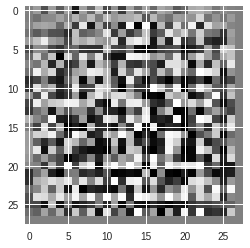

In [14]:
my_i = temp.squeeze()
plt.imshow(my_i, cmap='gray_r')
plt.show()

### Let’s look at how we can make our generator better. Enter loss functions and optimization!

In [0]:
batch_size = 16
tf.reset_default_graph() #Since we changed our batch size (from 1 to 16), we need to reset our Tensorflow graph

sess = tf.Session()
x_placeholder = tf.placeholder("float", shape = [None,28,28,1]) #Placeholder for input images to the discriminator
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions]) #Placeholder for input noise vectors to the generator

One of the trickiest parts about understanding GANs is that the loss function is a little bit more complex than that of a traditional CNN classifiers (For those, a simple MSE  would do the job). A GAN can be thought of as a zero sum minimax game. The generator is constantly improving to produce more and more realistic images, while the discriminator is trying to get better and better at distinguishing between real and generated images. This means that we need to formulate loss functions that affect both networks. Let’s take a look at the inputs and outputs of our networks.

In [0]:
Dx = discriminator(x_placeholder) #Dx will hold discriminator outputs (unnormalized) for the real MNIST images
Gz = generator(z_placeholder, batch_size, z_dimensions) #Gz holds the generated images
Dg = discriminator(Gz, reuse=True) #Dg will hold discriminator outputs (unnormalized) for generated images

We want the generator network to create images that will fool the discriminator. The generator wants the discriminator to output a 1 (positive example). Therefore, we want to compute the loss between the Dg and label of 1. This can be done through the tf.nn.sigmoid_cross_entropy_with_logits function. This means that the cross entropy loss will be taken between the two arguments. The "with_logits" component means that the function will operate on unscaled values. Basically, this means that instead of using a softmax function to squish the output activations to probability values from 0 to 1, we simply return the unscaled value of the matrix multiplication. Take a look at the last line of our discriminator. There's no softmax or sigmoid layer at the end.

The reduce mean function just takes the mean value of all of the components in the matrixx returned by the cross entropy function. This is just a way of reducing the loss to a single scalar value, instead of a vector or matrix.

In [0]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg)))

discriminator’s point of view. Its goal is to just get the correct labels (output 1 for each MNIST digit and 0 for the generated ones). We’d like to compute the loss between Dx and the correct label of 1 as well as the loss between Dg and the correct label of 0.

In [0]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))
d_loss = d_loss_real + d_loss_fake

Keep in mind that the optimizer for the generator network needs to only update the generator’s weights, not those of the discriminator. In order to make this distinction, we need to create 2 lists, one with the discriminator’s weights and one with the generator’s weights.

In [0]:
tvars = tf.trainable_variables()
d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

In [0]:
#Adam seems to be the best SGD optimizer as it utilizes adaptive learning rates and momentum
with tf.variable_scope(tf.get_variable_scope(), reuse=False):
    trainerD = tf.train.AdamOptimizer().minimize(d_loss, var_list=d_vars)
    trainerG = tf.train.AdamOptimizer().minimize(g_loss, var_list=g_vars)

In [0]:
sess.run(tf.global_variables_initializer())
iterations = 3000
for i in range(iterations):
    z_batch = np.random.normal(-1, 1, size=[batch_size, z_dimensions])
    real_image_batch = mnist.train.next_batch(batch_size)
    real_image_batch = np.reshape(real_image_batch[0],[batch_size,28,28,1])
    _,dLoss = sess.run([trainerD, d_loss],feed_dict={z_placeholder:z_batch,x_placeholder:real_image_batch}) #Update the discriminator
    _,gLoss = sess.run([trainerG,g_loss],feed_dict={z_placeholder:z_batch}) #Update the generator

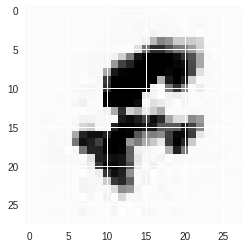

In [22]:
sample_image = generator(z_placeholder, 1, z_dimensions, reuse=True)
z_batch = np.random.normal(-1, 1, size=[1, z_dimensions])
temp = (sess.run(sample_image, feed_dict={z_placeholder: z_batch}))
my_i = temp.squeeze()
plt.imshow(my_i, cmap='gray_r')